<a href="https://colab.research.google.com/github/yebyyy/Automatic-Gradient-Descent-Library-Project/blob/main/MLP_%2B_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### Build the vocabulary

In [3]:
chars = sorted(list(set(''.join(words))))
stringToInt = {s:i+1 for i,s in enumerate(chars)}
stringToInt['.'] = 0
intToString = {i:s for s,i in stringToInt.items()}
vocab_size = len(intToString)
print(intToString)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Build the dataset

In [4]:
import random

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stringToInt[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [6]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP Revisited

In [7]:
n_embed = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)  # remember that we need to time block size
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters)

11897

In [9]:
for p in parameters:
  p.requires_grad = True

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  index = torch.randint(0,Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[index], Ytr[index]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i: 7d}/{max_steps: 7d} : {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000 : 27.8817
  10000/ 200000 : 2.9415
  20000/ 200000 : 2.5069
  30000/ 200000 : 2.7998
  40000/ 200000 : 2.0261
  50000/ 200000 : 2.5863
  60000/ 200000 : 2.3420
  70000/ 200000 : 2.0952
  80000/ 200000 : 2.3454
  90000/ 200000 : 2.2365
 100000/ 200000 : 2.1080
 110000/ 200000 : 2.3831
 120000/ 200000 : 1.9898
 130000/ 200000 : 2.4591
 140000/ 200000 : 2.1910
 150000/ 200000 : 2.1606
 160000/ 200000 : 2.1811
 170000/ 200000 : 1.7997
 180000/ 200000 : 2.0962
 190000/ 200000 : 1.8052


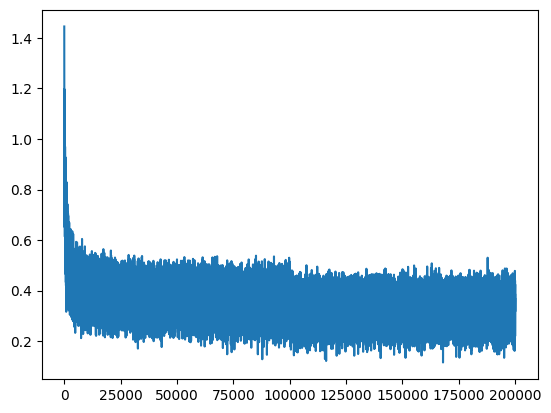

In [11]:
plt.plot(lossi)

In [14]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte)
  }[split]
  embed = C[x]
  embedcat = embed.view(embed.shape[0], -1)
  h = torch.tanh(embedcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [15]:
split_loss("train")

train 2.127678871154785


In [16]:
split_loss("val")

val 2.1750576496124268


In [24]:
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    embed = C[torch.tensor([context])]
    embedcat = embed.view(1, -1)
    h = torch.tanh(embedcat @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    index = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [index]
    out.append(index)
    if index == 0:
      break
  print(''.join(intToString[i] for i in out))

mora.
mayah.
seel.
nehayla.
remyra.
endrael.
adeer.
melin.
shy.
jen.
ede.
seananaraelyn.
malya.
cayshubergiaghan.
trickontelionnie.
cayus.
mace.
ryyah.
fael.
youe.
